# Implementazione dell'algoritmo di Grover in qiskit

L'algoritmo di Grover, risolve un problema di ricerca in un database.   Questo algoritmo può anche servire come subroutine per ottenere miglioramenti quadratici dei tempi di esecuzione in altri algoritmi.

Consideriamo un elenco con $0$ - $N$ elementi. In questa lista c'è un oggetto particolare, $w$, che vogliamo localizzare.

|$0$|$0$|$0$||$1$||$0$|$0$|
|-|-|-|-|-|-|-|-|
|$0$|$1$|$2$|...|$w$|...|$N-1$|$N=2^n$|

In un computer classico, lo scenario peggiore ci costringerebbe a testare tutti gli $N$ oggetti prima di trovare quello desiderato, e in media dovremmo testare $N/2$ oggetti. Con l'algoritmo di Grover, l'oggetto desiderato si trova in $sqrt{N}$ passi. Inoltre, questo algoritmo è anche generico perché non utilizza la struttura interna dell'elenco.

In questo algoritmo è fondamentale avere un oracolo. Un esempio semplice di tale funzione è:

$$f(x)=0$$
$$f(w)=1$$

<img src="https://scx2.b-cdn.net/gfx/news/2018/groversearch.jpg" alt="Note: In order for images to show up in this jupyter notebook you need to select File => Trusted Notebook" width="800 px" align="center">

I 3 step dell'algoritmo di Grover: initializzazione, oracolo, amplificazione.

In [1]:
from qiskit import Aer, IBMQ
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister
from qiskit import execute, transpile

from qiskit.tools.visualization import plot_histogram, plot_state_city, plot_state_hinton

import matplotlib.pyplot as plt
%matplotlib inline

**1** Inizializzazione in sovrapposizione di stati:

$$ \lvert \psi \rangle = \sum_{x_i} \lvert x_i \rangle$$

**2** Applicazione $\sqrt{N}$ volte l'operatore $U_w$, necessario per individuare la soluzione al problema:


$$ \lvert \psi \rangle = -\alpha_m \lvert x_m \rangle + \beta \sum_{x_i \neq x_m}\lvert x_i \rangle$$ 

Con questa implementazione, la fase dello stato voluto ($f(x_m) = 1$) ruota di $\pi$, mentre gli altri stati non vengono modificati.

# Codice

Voglio usare l'algoritmo di Grover cercando tra gli hash di una password. Come prima cosa creo un esempio di funzione di hashing. Questa funzione prende in ingresso 2 bit, che identificano un valore in un dizionario di 4 elementi (A, B, C, D), e restituisce 3 bit che compongono l'hash (identificato da un numero):

|message|input||hash|number|
|-|-|-|-|-|
|A|00|-->|010|2|
|B|01|-->|110|6|
|C|10|-->|111|7|
|D|11|-->|000|0|



In [2]:
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister, Aer, execute
from qiskit.circuit.library import MCMT, ZGate
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

In [3]:
from qiskit.circuit.library import GroverOperator
from qiskit.tools.visualization import plot_histogram

In [4]:
def create_hash_gate():
    qu_in = QuantumRegister(2, 'in')
    qu_out = QuantumRegister(3, 'out')


    hash_circuit = QuantumCircuit(qu_in,qu_out)

    hash_circuit.cx(qu_in[0],qu_out[0])
    hash_circuit.cx(qu_in[1],qu_out[0])
    hash_circuit.toffoli(qu_in[0],qu_in[1],qu_out[1])
    hash_circuit.x(qu_out[1])
    hash_circuit.toffoli(qu_in[0],qu_in[1],qu_out[2])
    hash_circuit.cx(qu_in[0],qu_out[2])
    
    #hash_gate = circuit_to_gate(hash_circuit, label='Hash' )

    #return hash_gate
    return hash_circuit

In [5]:
def create_oracle(number_qubit_message, number_qubit_hash, hash, create_hash_gate):
    
    qr_in = QuantumRegister(number_qubit_message, name='in')
    qr_ha = QuantumRegister(number_qubit_hash, name='hash')

    circ = QuantumCircuit(qr_in, qr_ha)
    
    ###############################################
    # create hash gate
    hash_gate = create_hash_gate()

    circ.append(hash_gate, [*qr_in, *qr_ha])

    ###################################
    # modify the circuit using the hash

    # if hash does not exist in table 1, no state's phase is flipped 


    for i, b in enumerate(hash):
        if b=='0' :
            circ.x(qr_ha[i])



    ############## C^nZ


    circ.append(MCMT(ZGate(),number_qubit_hash-1,1),[*qr_ha])


    ##############################################
    # invert hash gate to reset hash_qubit / set 0 
    # classically should be impossible
    #
    # modify the circuit using the hash

    for i, b in enumerate(hash):
        if b=='0' :
            circ.x(qr_ha[i])


    inverse_hash_gate = hash_gate.inverse()
    circ.append(inverse_hash_gate, [*qr_in, *qr_ha])



    ##############################
    
    return circ


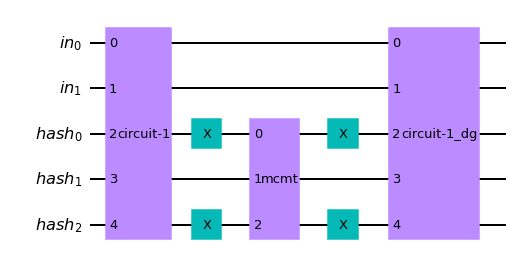

In [6]:
create_oracle(2, 3 , '010', create_hash_gate).draw(output = 'mpl')

In [7]:
def read_statevector(vec):
    
    n = int(np.log2(len(vec)))
    word="0"+str(n)+"b"
    dict = {}

    for i in range(0,pow(2,n)):
        base=format(i,word)
        #print(base)
        dict[base] = vec[i]
        
    return dict

# Grover's Operator

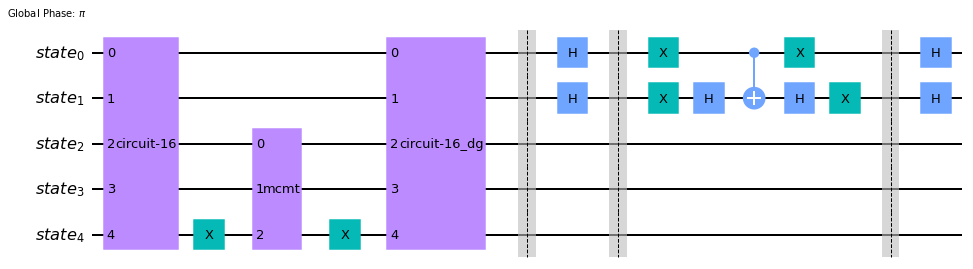

In [8]:
# GroverOperator = ORACLE + DIFFUSER
number_qubit_message = 2
number_qubit_hash = 3

oracle = create_oracle(number_qubit_message, number_qubit_hash, '110', create_hash_gate)

grover_op = GroverOperator(oracle,  reflection_qubits=list(range(number_qubit_message)), insert_barriers=True) # oracle is a circuit, not a gate. reflection_qubit = to search on
grover_op.decompose().draw(output='mpl')

# Circuit

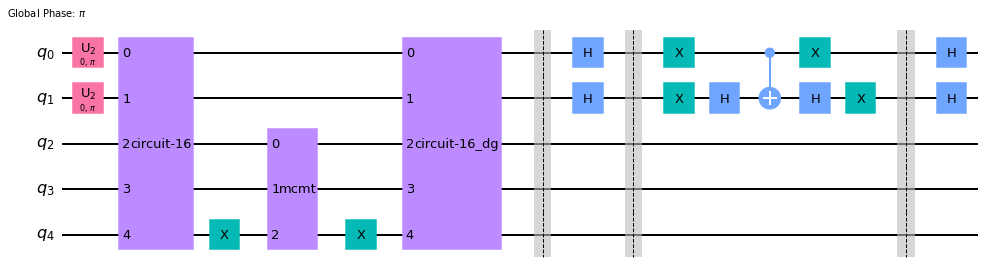

In [9]:
grover_cir = QuantumCircuit(5)
grover_cir.h([0,1])
grover_cir = grover_cir.compose(grover_op)
grover_cir.decompose().draw(output='mpl')

# Statevector Simulation

In [10]:
backend_state = Aer.get_backend('statevector_simulator') 

In [11]:
result = execute(grover_cir, backend_state).result()
state  = result.get_statevector(grover_cir)
read_statevector(np.around(state,2))

{'00000': -0j,
 '00001': (-0+0j),
 '00010': (1+0j),
 '00011': (-0+0j),
 '00100': 0j,
 '00101': 0j,
 '00110': 0j,
 '00111': 0j,
 '01000': -0j,
 '01001': -0j,
 '01010': -0j,
 '01011': -0j,
 '01100': 0j,
 '01101': 0j,
 '01110': 0j,
 '01111': 0j,
 '10000': 0j,
 '10001': -0j,
 '10010': -0j,
 '10011': 0j,
 '10100': 0j,
 '10101': 0j,
 '10110': 0j,
 '10111': 0j,
 '11000': (-0-0j),
 '11001': (-0-0j),
 '11010': (-0-0j),
 '11011': (-0-0j),
 '11100': 0j,
 '11101': 0j,
 '11110': 0j,
 '11111': 0j}

# Measurement Simulation

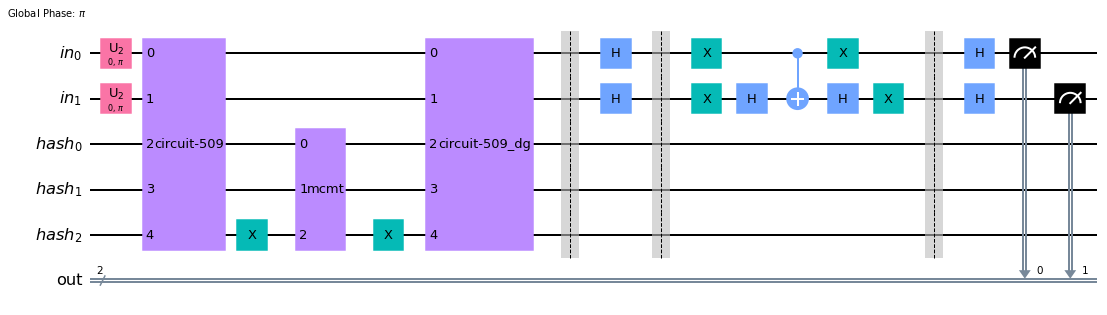

In [12]:
# input

number_qubit_message = 2
number_qubit_hash = 3

hash = '110'

####################################################################

index_message = list(range(number_qubit_message))

qr_in = QuantumRegister(number_qubit_message, name='in')
qr_ha = QuantumRegister(number_qubit_hash, name='hash')
cl_r = ClassicalRegister(number_qubit_message, name='out')

circuit = QuantumCircuit(qr_in, qr_ha, cl_r)

# State superposition

circuit.h(qr_in)

# Grover's Operator

oracle = create_oracle(number_qubit_message, number_qubit_hash, hash , create_hash_gate)
grover_op = GroverOperator(oracle,  reflection_qubits=list(range(number_qubit_message)), insert_barriers=True) # oracle is a circuit, not a gate. reflection_qubit = to search on

    #(for _ in floor(sqrt(number_qubit_message)) 
circuit = circuit.compose(grover_op)


# Measurement

circuit.measure(qr_in, cl_r)
circuit.decompose().draw(output='mpl')


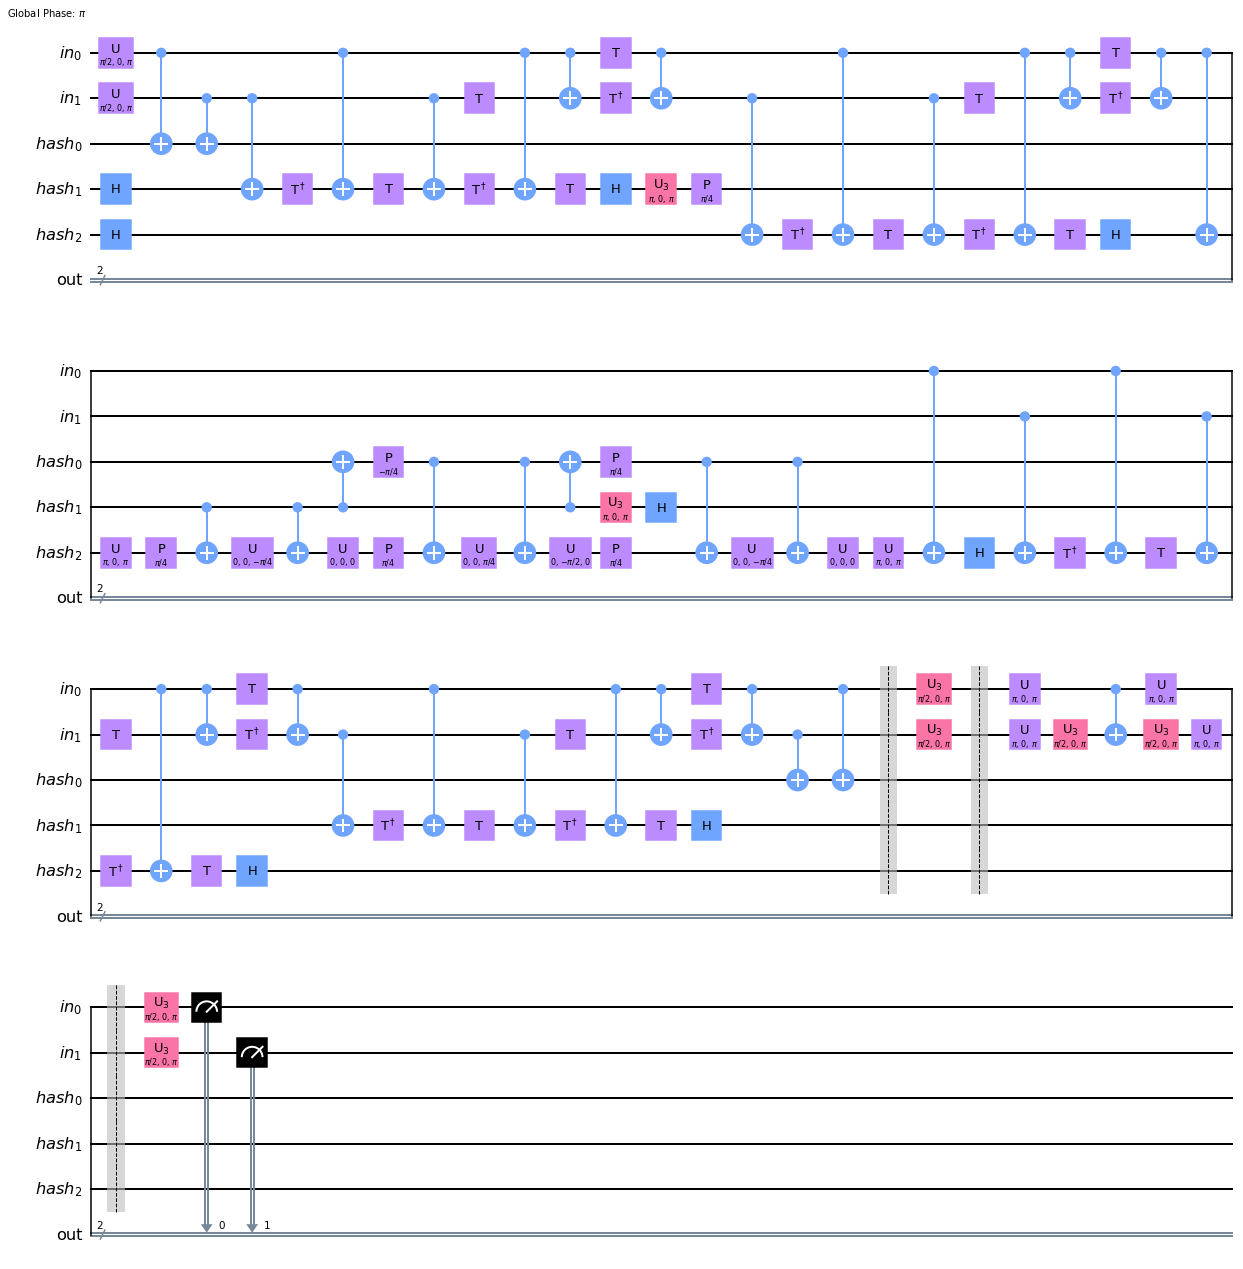

In [13]:
circuit.decompose().decompose().decompose().draw(output='mpl')


|message|input||hash|number|
|-|-|-|-|-|
|A|00|-->|010|2|
|B|01|-->|110|6|
|C|10|-->|111|7|
|D|11|-->|000|0|



In [14]:
backend = Aer.get_backend("qasm_simulator")

{'10': 100}
Il messaggio trovato è 01 (attenzione all'endianess)


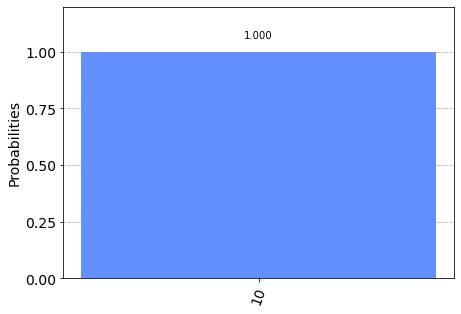

In [15]:
job = execute(circuit, backend, shots=100)
result = job.result()
counts = result.get_counts(circuit)
print(counts)
print(f"Il messaggio trovato è {max(counts, key = counts.get)[::-1]} (attenzione all'endianess)")
plot_histogram(counts)


# Real Quantum Computer

In [1]:
from qiskit import IBMQ

In [24]:
#save_account needs to be run only once
#IBMQ.save_account('your_IBM_api_ID')

In [2]:
provider = IBMQ.load_account()
provider.backends()

[<IBMQSimulator('ibmq_qasm_simulator') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_lima') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_belem') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_quito') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQSimulator('simulator_statevector') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQSimulator('simulator_mps') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQSimulator('simulator_extended_stabilizer') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQSimulator('simulator_stabilizer') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_manila') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibm_nairobi') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibm_oslo') from IBMQ(hub='ibm-q', group='open', project='main')>]

In [5]:
import qiskit.tools.jupyter

%qiskit_backend_overview

In [4]:
from qiskit.tools.monitor import backend_overview, backend_monitor

backend_overview()

ibm_oslo                     ibm_nairobi                  ibmq_manila
--------                     -----------                  -----------
Num. Qubits:  7              Num. Qubits:  7              Num. Qubits:  5
Pending Jobs: 137            Pending Jobs: 27             Pending Jobs: 33
Least busy:   False          Least busy:   False          Least busy:   False
Operational:  True           Operational:  True           Operational:  True
Avg. T1:      148.7          Avg. T1:      121.5          Avg. T1:      166.4
Avg. T2:      98.7           Avg. T2:      53.3           Avg. T2:      58.2



ibmq_quito                   ibmq_belem                   ibmq_lima
----------                   ----------                   ---------
Num. Qubits:  5              Num. Qubits:  5              Num. Qubits:  5
Pending Jobs: 21             Pending Jobs: 18             Pending Jobs: 40
Least busy:   False          Least busy:   True           Least busy:   False
Operational:  True           Operat

In [28]:
backend_device = provider.get_backend('ibmq_belem')
print("Running on: ", backend_device)

Running on:  ibmq_belem


In [29]:
# See backend information
backend_device

<IBMQBackend('ibmq_belem') from IBMQ(hub='ibm-q', group='open', project='main')>

In [30]:
backend_monitor(backend_device)

ibmq_belem
Configuration
-------------
    n_qubits: 5
    operational: True
    status_msg: active
    pending_jobs: 9
    backend_version: 1.0.34
    basis_gates: ['id', 'rz', 'sx', 'x', 'cx', 'reset']
    local: False
    simulator: False
    uchannels_enabled: True
    meas_levels: [1, 2]
    clops: 2454
    conditional: False
    qubit_lo_range: [[4.590225319976792, 5.590225319976792], [4.74554017230416, 5.74554017230416], [4.861453674917008, 5.861453674917008], [4.670370452098721, 5.670370452098721], [4.7584588375707835, 5.758458837570784]]
    acquisition_latency: []
    rep_times: [1000.0]
    coupling_map: [[0, 1], [1, 0], [1, 2], [1, 3], [2, 1], [3, 1], [3, 4], [4, 3]]
    credits_required: True
    open_pulse: False
    online_date: 2021-01-08 05:00:00+00:00
    timing_constraints: {'acquire_alignment': 16, 'granularity': 16, 'min_length': 64, 'pulse_alignment': 1}
    pulse_num_qubits: 3
    url: None
    supported_features: ['qobj']
    rep_delay_range: [0.0, 500.0]
    pa

In [31]:
%qiskit_job_watcher

Accordion(children=(VBox(layout=Layout(max_width='710px', min_width='710px')),), layout=Layout(max_height='500…

<IPython.core.display.Javascript object>

In [32]:
job_r = execute(circuit, backend_device, shots=100)

jobID_r = job_r.job_id()

print('JOB ID: {}'.format(jobID_r))

JOB ID: 6212a1433255f7c05f02c73b


In [33]:
job_get=backend_device.retrieve_job('6212a1433255f7c05f02c73b')
result_r = job_get.result()
counts_run = result_r.get_counts(circuit)

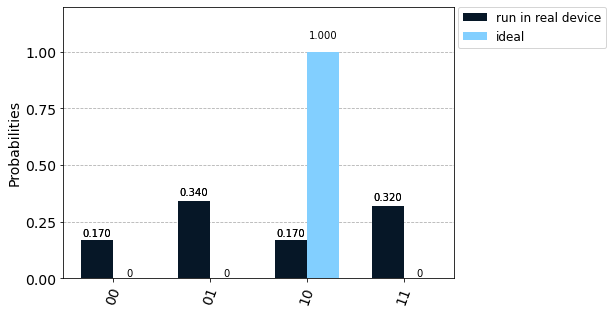

In [34]:
plot_histogram([counts_run, counts ], legend=[ 'run in real device', 'ideal'], color=['#061727','#82cfff'])

# Noise Mitigation

In [35]:
# Import measurement calibration functions
from qiskit.ignis.mitigation.measurement import (complete_meas_cal, tensored_meas_cal,
                                                 CompleteMeasFitter, TensoredMeasFitter)

/tmp/ipykernel_4128/307438614.py:2: DeprecationWarning: The qiskit.ignis package is deprecated and has been supersceded by the qiskit-experiments project. Refer to the migration guide: https://github.com/Qiskit/qiskit-ignis#migration-guide on how to migrate to the new project.
  from qiskit.ignis.mitigation.measurement import (complete_meas_cal, tensored_meas_cal,
